In [6]:
import logging
import torch
import nni.retiarii.nn.pytorch as nn

from collections import OrderedDict
from nni.retiarii import model_wrapper

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# new space test

In [7]:
# # let's make the DARST search space:
# it's comprised of the following:
# Max pooling 3x3
# Average pooling 3x3
# Skip connect (Identity)
# Separable convolution 3x3
# Separable convolution 5x5
# Dilated convolution 3x3
# Dilated convolution 5x5

class Block(nn.Module):
    def __init__(self):
        super(Block, self).__init__()

    def SeparableConv2d(self, in_channels, out_channels, kernel, activation):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=kernel, stride=1, padding=(kernel - 1) // 2, dilation=1, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1),            
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel, stride=1, padding=(kernel - 1) // 2, dilation=1, groups=out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1),
            nn.BatchNorm2d(out_channels),
            activation
            )

    def DilatedConv2d(self, in_channels, out_channels, kernel, dilation, activation):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel, stride=1, padding=(kernel - 1) // 2, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel, stride=1, padding=(kernel - 1) // 2, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            activation
            )
    
    def get_blocks(self, in_channels, out_channels, activation):
        blocks = OrderedDict([    
            ('SeparableConv2d_3x3', self.SeparableConv2d(in_channels, out_channels, kernel=3, activation=activation)),
            ('SeparableConv2d_5x5', self.SeparableConv2d(in_channels, out_channels, kernel=5, activation=activation)),
            ('DilatedConv2d_3x3', self.DilatedConv2d(in_channels, out_channels, kernel=3, dilation=2, activation=activation)),
            ('DilatedConv2d_5x5', self.DilatedConv2d(in_channels, out_channels, kernel=5, dilation=2, activation=activation)),
        ])
        return blocks
    
    def get_pools(self):
        pools = OrderedDict([
            ('MaxPool2d', nn.MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)),
            ('AvgPool2d', nn.AvgPool2d(kernel_size=3, stride=1, padding=1))
        ])
        return pools
    
    def get_upsamples(self):
        upsamples = OrderedDict([
            ("Nearest", nn.Upsample(scale_factor=2,mode='nearest')),
            ("Bilinear", nn.Upsample(scale_factor=2,mode='bilinear', align_corners=True))
        ])
        return upsamples

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

class EncoderBlock(Block):
    def __init__(self, in_channels, out_channels, activation, layer_name):
        super(EncoderBlock, self).__init__()
        
        self.downsample = nn.LayerChoice(self.get_pools(),label=f'{layer_name} - Step 1: Downsample')
        self.conv = nn.LayerChoice(self.get_blocks(in_channels,out_channels,activation),label=f'{layer_name} - Step 2: Convolution')

    def forward(self, x):
        x = self.downsample(x)
        x = self.convconv_layer(x)
        return x
    
class DecoderBlock(Block):
    def __init__(self, in_channels, out_channels, activation, layer_name="Decoder []"):
        super(DecoderBlock, self).__init__()
        
        self.upsample = nn.LayerChoice(self.get_upsamples(),label=f'{layer_name} - Step 1: Upsample')
        self.conv = nn.LayerChoice(self.get_blocks(in_channels,out_channels,activation),label=f'{layer_name} - Step 2: Convolution')

    def forward(self, x, skip):
        upsampled = self.upsample(x)
        cropped = self.crop_tensor(upsampled, skip)
        return self.conv_layer(torch.cat([cropped, upsampled], 1))

    

In [8]:

activations = OrderedDict([
    ("RelU", nn.ReLU(inplace=True)),
    ("Sigmoid", nn.Sigmoid()),
    ("SiLU", nn.SiLU(inplace=True)),
])

DecoderBlock(3,16,activations)

TypeError: OrderedDict is not a Module subclass

In [ ]:

@model_wrapper
class SearchSpace(Block):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        network_depth = nn.ValueChoice([1, 2, 3, 4], label="Network Depth")
        # maybe can use max of depth to create a better label down in the decoder_block = ... line below

        activations = OrderedDict([
            ("RelU", nn.ReLU(inplace=True)),
            ("Sigmoid", nn.Sigmoid()),
            ("SiLU", nn.SiLU(inplace=True)),
        ])

        # Conv layer in"
        self.mid_channels = 64
        self.conv = nn.LayerChoice(self.get_blocks(in_channels,out_channels,activations),label=f'{"First Conv Layer"} - Step 1: Convolution')


        # For Encoders:
        encoder_block = lambda index: EncoderBlock(64*(2**index), 64*(2**(index+1)), activations, f"Encoder {index+1}")
        self.encoders = nn.Repeat(encoder_block, network_depth)

        # For Decoders:
        decoder_block = lambda index: DecoderBlock(64*(2**(index))*3, 64*(2**index), activations, f"Decoder {index+1}")
        self.decoders = nn.Repeat(decoder_block, network_depth)
        self.decoders = self.decoders[::-1]

        # Conv layer out
        self.out = nn.Conv2d(64, out_channels, kernel_size=1, padding=0, dilation=1)
        
    def forward(self, x):
        logger.info("Input: %s", x.size())
        
        # Variables to store intermediate values
        encoder_outputs = []

        # Start with the first conv layer
        x = self.first(x)
        encoder_outputs.append(x)
        logger.info(f"Initial Conv Layer: %s", x.size())

        # Encoder pass
        for i, encoder in enumerate(self.encoders):
            x = encoder(x)
            encoder_outputs.append(x)
            logger.info(f"Encoder {i+1}: %s", x.size())

        # Decoder pass
        for i, decoder in enumerate(self.decoders):
            x = decoder(x, encoder_outputs[-(i+2)])
            logger.info(f"Decoder {len(self.decoders) - i}: %s", x.size())

        x = self.out(x)
        logger.info("Output: %s", x.size())
        return x

In [ ]:
import nni.retiarii.strategy as strategy

from utils import main_evaluation

from nni.experiment import Experiment
from nni.retiarii.evaluator import FunctionalEvaluator
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig

In [ ]:
# search space
model_space = SearchSpace()
evaluator = FunctionalEvaluator(main_evaluation)

# search strategy
search_strategy = strategy.Random(dedup=True)

# experiment
exp = RetiariiExperiment(model_space, evaluator, [], search_strategy)
exp_config = RetiariiExeConfig('local')
exp_config.experiment_name = 'mnist_search'
exp_config.trial_code_directory = 'C:/Users/Public/Public_VS_Code/NAS_test'
exp_config.experiment_working_directory = 'C:/Users/Public/nni-experiments'

exp_config.max_trial_number = 12   # spawn 50 trials at most
exp_config.trial_concurrency = 2  # will run two trials concurrently

exp_config.trial_gpu_number = 1 # will run 1 trial(s) concurrently
exp_config.training_service.use_active_gpu = True

# Execute
exp.run(exp_config, 8081)

TypeError: OrderedDict is not a Module subclass

# test noise

Testing gaussian noise...


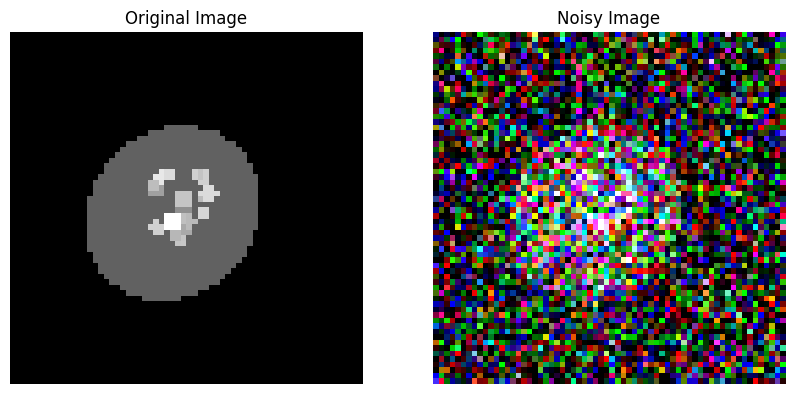

Testing salt_and_pepper noise...


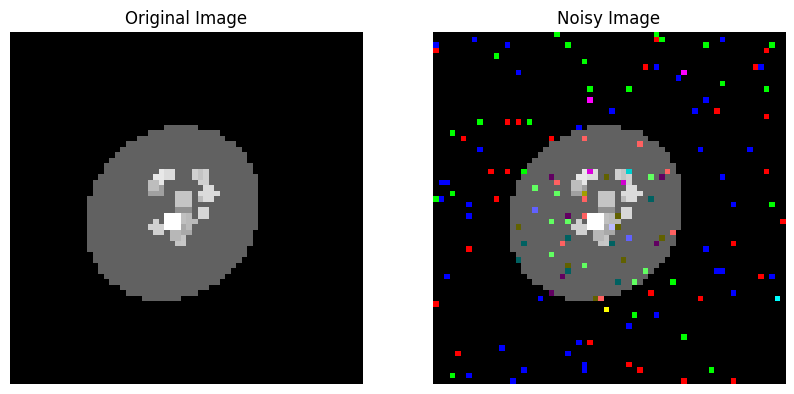

Testing speckle noise...


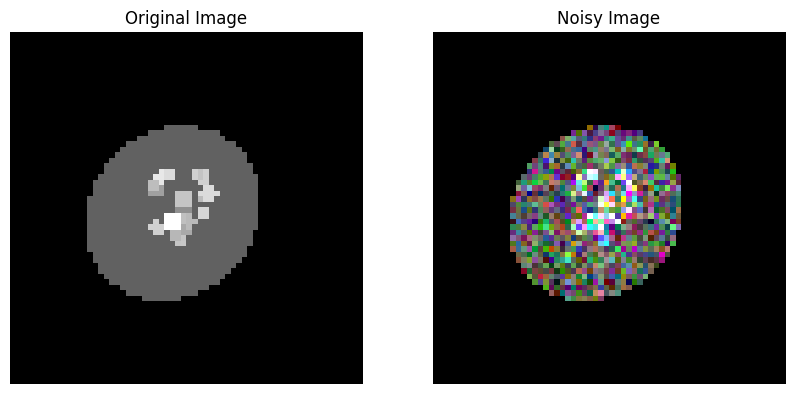

Testing poisson noise...


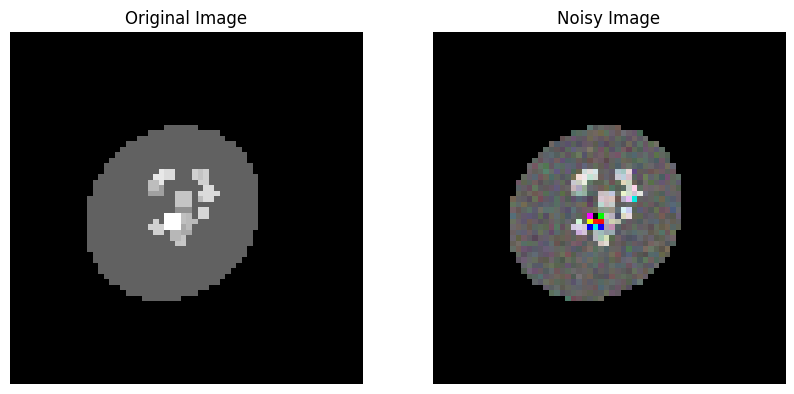

Testing uniform noise...


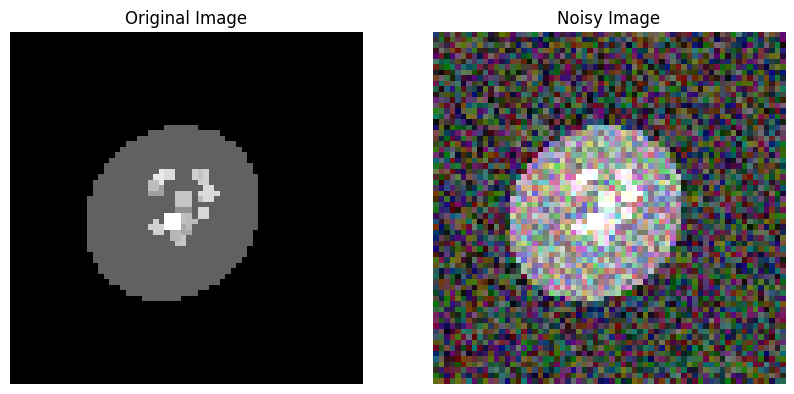

Testing exponential noise...


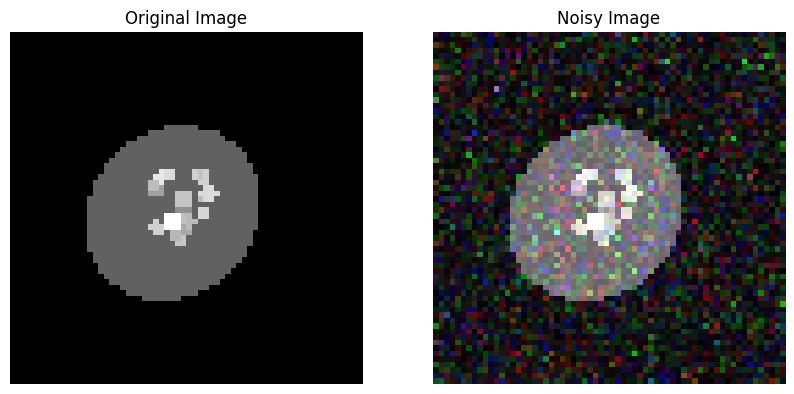

Testing rayleigh noise...


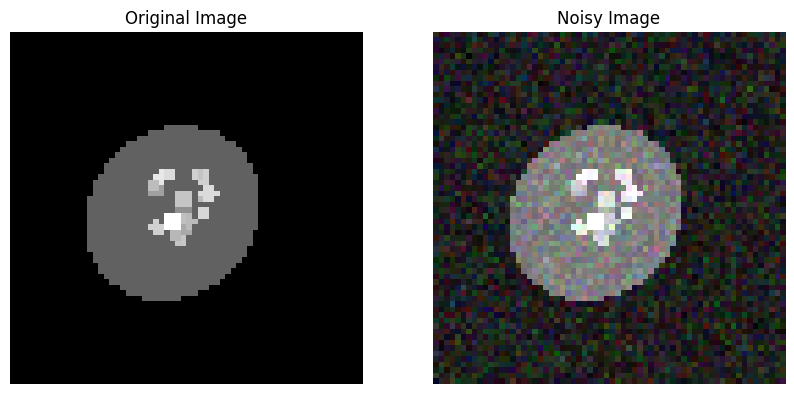

Testing erlang noise...


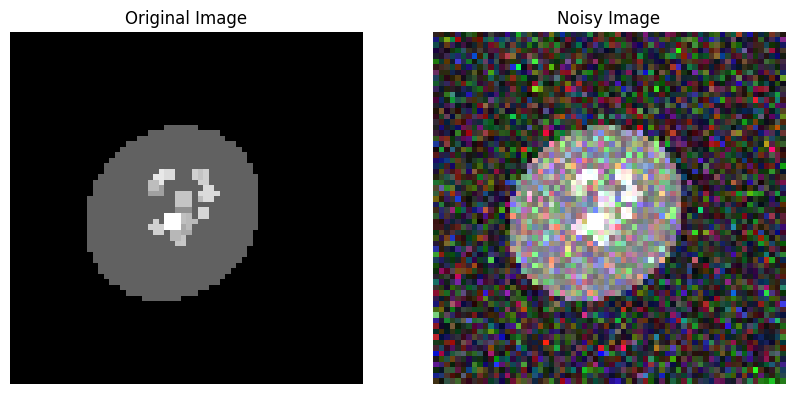

Testing brownian noise...


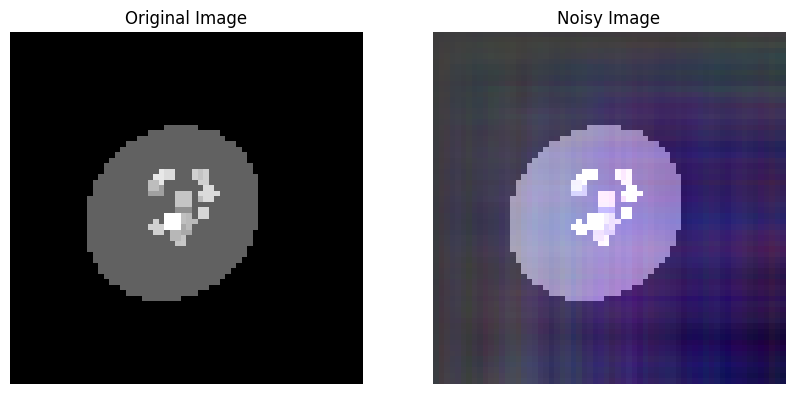

Testing quantization noise...


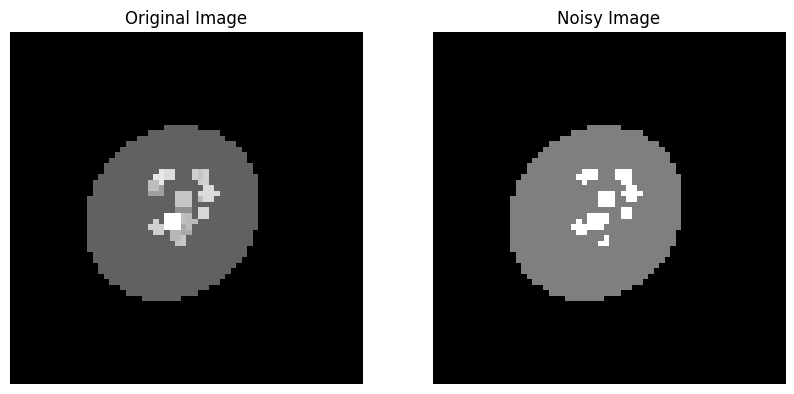

Testing stripe noise...


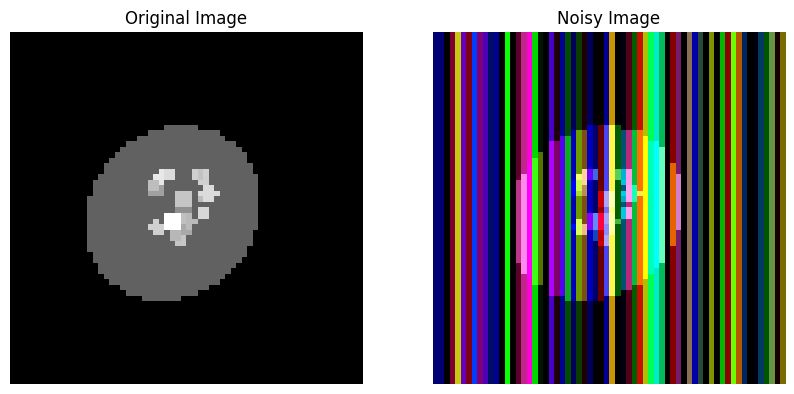

Testing multiplicative noise...


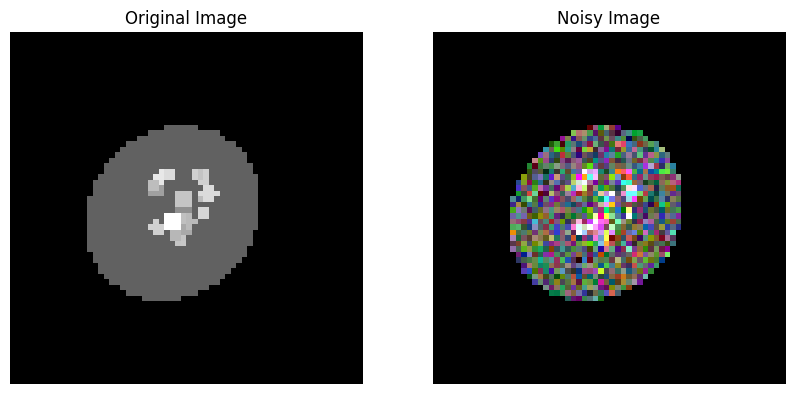

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from noises import *
from utils import *
from phantom import generate_phantom, phantom_to_torch


def display_images(original, noisy):
    plt.figure(figsize=(10, 5))
    
    # Displaying the original image
    plt.subplot(1, 2, 1)
    plt.imshow(TF.to_pil_image(original))
    plt.title("Original Image")
    plt.axis('off')
    
    # Displaying the noisy image
    plt.subplot(1, 2, 2)
    plt.imshow(TF.to_pil_image(noisy))
    plt.title("Noisy Image")
    plt.axis('off')
    
    plt.show()

def test_noise_functions():
    # Generate the phantom image and convert the numpy img to torch tensor
    img_numpy = generate_phantom(resolution=6)
    img = phantom_to_torch(img_numpy)
    
    for noise_name, noise_func in NOISE_FUNCTIONS.items():
        noisy_img = add_selected_noise(img, noise_type=noise_name)
        print(f"Testing {noise_name} noise...")
        display_images(img, noisy_img)

if __name__ == "__main__":
    test_noise_functions()

# test old space with phantoms

In [12]:
import nni.retiarii.strategy as strategy

from darts.space import SearchSpace
from darts.eval import main_evaluation

from nni.experiment import Experiment
from nni.retiarii.evaluator import FunctionalEvaluator
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig

In [13]:
# search space
model_space = SearchSpace()
evaluator = FunctionalEvaluator(main_evaluation)

# search strategy
search_strategy = strategy.Random(dedup=True)

# experiment
exp = RetiariiExperiment(model_space, evaluator, [], search_strategy)
exp_config = RetiariiExeConfig('local')
exp_config.experiment_name = 'mnist_search'
exp_config.trial_code_directory = 'C:/Users/Public/Public_VS_Code/NAS_test'
exp_config.experiment_working_directory = 'C:/Users/Public/nni-experiments'

exp_config.max_trial_number = 12   # spawn 50 trials at most
exp_config.trial_concurrency = 2  # will run two trials concurrently

exp_config.trial_gpu_number = 1 # will run 1 trial(s) concurrently
exp_config.training_service.use_active_gpu = True

# Execute
exp.run(exp_config, 8081)

[2023-08-14 12:23:44] Creating experiment, Experiment ID: xkh3fsoy


2023-08-14 12:23:44,763 - INFO - Creating experiment, Experiment ID: ${CYAN}xkh3fsoy


[2023-08-14 12:23:44] Starting web server...


2023-08-14 12:23:44,773 - INFO - Starting web server...


[2023-08-14 12:23:45] Setting up...


2023-08-14 12:23:45,873 - INFO - Setting up...


[2023-08-14 12:23:45] Web portal URLs: http://169.254.138.100:8081 http://169.254.67.161:8081 http://169.254.50.13:8081 http://10.0.0.172:8081 http://127.0.0.1:8081


2023-08-14 12:23:45,983 - INFO - Web portal URLs: ${CYAN}http://169.254.138.100:8081 http://169.254.67.161:8081 http://169.254.50.13:8081 http://10.0.0.172:8081 http://127.0.0.1:8081


[2023-08-14 12:23:45] Dispatcher started


2023-08-14 12:23:45,992 - INFO - Dispatcher started


[2023-08-14 12:23:46] Start strategy...


2023-08-14 12:23:46,016 - INFO - Start strategy...


[2023-08-14 12:23:46] Successfully update searchSpace.


2023-08-14 12:23:46,075 - INFO - Successfully update searchSpace.


[2023-08-14 12:23:46] Random search running in fixed size mode. Dedup: on.


2023-08-14 12:23:46,078 - INFO - Random search running in fixed size mode. Dedup: on.


[2023-08-14 12:29:15] Strategy exit


2023-08-14 12:29:15,509 - INFO - Strategy exit


[2023-08-14 12:29:15] Search process is done, the experiment is still alive, `stop()` can terminate the experiment.


2023-08-14 12:29:15,541 - INFO - Search process is done, the experiment is still alive, `stop()` can terminate the experiment.


In [14]:
experiment = Experiment.connect(8081)
experiment.stop()

[2023-08-14 12:29:44] Connect to port 8081 success, experiment id is xkh3fsoy, status is DONE.


2023-08-14 12:29:44,332 - INFO - Connect to port 8081 success, experiment id is xkh3fsoy, status is DONE.


[2023-08-14 12:29:44] Stopping experiment, please wait...


2023-08-14 12:29:44,333 - INFO - Stopping experiment, please wait...


[2023-08-14 12:29:44] Experiment stopped


2023-08-14 12:29:44,353 - INFO - Experiment stopped


[2023-08-14 12:29:44] Dispatcher exiting...


2023-08-14 12:29:44,359 - INFO - Dispatcher exiting...


[2023-08-14 12:29:46] Dispatcher terminiated


2023-08-14 12:29:46,726 - INFO - Dispatcher terminiated


# new space